# **Instalación y preparación de datos**

In [41]:
!pip install pymssql
!pip install pandas

In [42]:
!pip install sqlalchemy pymssql pandas

import pandas as pd
from sqlalchemy import create_engine

# Datos de conexión
server = 'serveo.net:37485'
database = 'Portafolio'
username = 'sa'
password = 'perro1234'

# Crear la conexión usando SQLAlchemy
connection_string = f"mssql+pymssql://{username}:{password}@{server}/{database}"
engine = create_engine(connection_string)

# Escribir la consulta
query = "SELECT TOP 10 * FROM Siniestro"

# Leer los datos con pandas
df = pd.read_sql(query, con=engine)

# Mostrar los primeros registros
df.head()

,id,clave_referencia,fecha,hora,perdidas_materiales,afectados,descripcion,implementos_utilizados,tipo_siniestro_id,comuna_id,bombero_id,usuario_id
0,1,REF001,2023-01-01,12:00:00,Alta,5 personas,Incendio en edificio,"Mangueras, Escaleras",1,1,1,1
1,2,REF002,2023-01-02,14:30:00,Moderada,2 personas,Inundación en planta baja,Escaleras,2,2,2,2
2,3,REF003,2023-01-03,08:00:00,Baja,Ninguno,Pequeño incendio en vehículo,Extintores,4,3,3,3
3,4,REF004,2023-01-04,16:45:00,Alta,10 personas,Explosión en fábrica,"Escaleras, Mangueras",5,4,4,4
4,5,REF005,2023-01-05,22:15:00,Moderada,3 personas,Accidente vehicular múltiple,Escaleras,4,5,5,5


In [43]:
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES"
tables = pd.read_sql(query, con=engine)

In [44]:
# Consulta para cargar toda la tabla 'Siniestro'
query = "SELECT * FROM Siniestro"
# Cargar los datos en un DataFrame de pandas
df_siniestro = pd.read_sql(query, con=engine)

In [45]:
# Consulta para cargar la tabla 'comuna'
query = "SELECT * FROM Comuna"
# Cargar los datos en un DataFrame de pandas
df_comuna = pd.read_sql(query, con=engine)

In [46]:
# Consulta para cargar la tabla 'Ciudad'
query = "SELECT * FROM Ciudad"
# Cargar los datos en un DataFrame de pandas
df_ciudad = pd.read_sql(query, con=engine)

In [47]:
#Limpieza de datos
print(df_siniestro.isnull().sum())
#Revisión de valores únicos
print(df_siniestro['perdidas_materiales'].unique())
print(df_siniestro['afectados'].unique())

id                        0
clave_referencia          0
fecha                     0
hora                      0
perdidas_materiales       0
afectados                 0
descripcion               0
implementos_utilizados    0
tipo_siniestro_id         0
comuna_id                 0
bombero_id                0
usuario_id                0
dtype: int64
['Alta' 'Moderada' 'Baja']
['5 personas' '2 personas' 'Ninguno' '10 personas' '3 personas'
 '8 personas' '4 personas' '7 personas' '12 personas' '15 personas'
 '20 personas' '1 persona' '2' '3' '4' '5' '6' '7' '8' '9' '10' '1']


# **Random Forest**

In [48]:
#Transformar los datos categóricos
df_siniestro['perdidas_materiales'] = df_siniestro['perdidas_materiales'].map({'Alta': 3, 'Moderada': 2, 'Baja': 1, 'Ninguna': 0})
df_siniestro['afectados'] = df_siniestro['afectados'].str.extract('(\d+)').astype(float)

In [49]:
# Crear variables dummy para implementos_utilizados
df_siniestro = pd.get_dummies(df_siniestro, columns=['implementos_utilizados'], drop_first=True)

In [50]:
# Convertir hora a formato numérico (hora en formato 24h)
df_siniestro['hora'] = pd.to_datetime(df_siniestro['hora'], format='%H:%M:%S').dt.hour

# Opcional: Categorizar por turnos
df_siniestro['turno'] = pd.cut(
    df_siniestro['hora'],
    bins=[-1, 6, 12, 18, 24],  # Dividimos en madrugada, mañana, tarde, noche
    labels=['madrugada', 'mañana', 'tarde', 'noche']
)
df_siniestro = pd.get_dummies(df_siniestro, columns=['turno'], drop_first=True)

In [51]:
print(df_siniestro['comuna_id'].isnull().sum())  # Asegurarse de que no tenga NaNa

0


In [52]:
X = df_siniestro[['afectados', 'tipo_siniestro_id', 'comuna_id', 'hora'] + list(df_siniestro.columns[df_siniestro.columns.str.startswith('implementos_utilizados_')])]
y = df_siniestro['perdidas_materiales']

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Crear el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)


# Hacer predicciones
y_pred = rf_model.predict(X_test)


# Precisión general
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.88
Matriz de confusión:
[[87  2 12]
 [ 9 86  2]
 [ 4  6 96]]
Informe de clasificación:
              precision    recall  f1-score   support

           1       0.87      0.86      0.87       101
           2       0.91      0.89      0.90        97
           3       0.87      0.91      0.89       106

    accuracy                           0.88       304
   macro avg       0.89      0.88      0.89       304
weighted avg       0.89      0.88      0.88       304



# **Predicciones**

In [55]:
# Ajustar las variables
X = df_siniestro[['afectados', 'hora', 'comuna_id']]
y = df_siniestro['tipo_siniestro_id']

# Dividir datos y entrenar el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_tipo = rf_model.predict(X_test)
print("Predicciones (tipo de siniestro):", y_pred_tipo[:10])  # Primeras 10 predicciones

Predicciones (tipo de siniestro): [43 46  4 26 29 12 21 22 40  9]


<ipython-input-56-01432f531fb3>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_count.index, y=pred_count.values, palette='viridis')


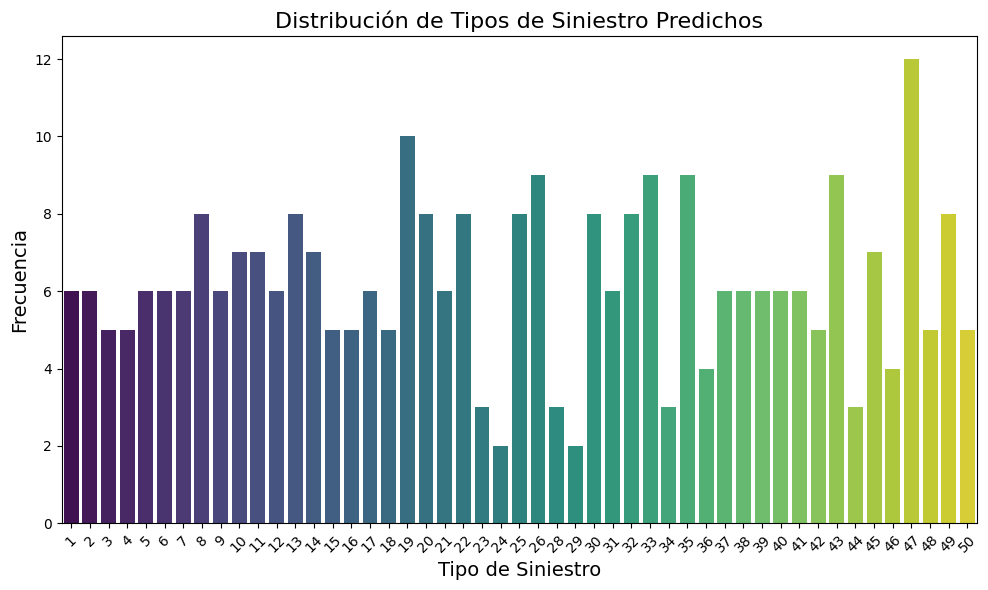

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Contar las predicciones por tipo de siniestro
pred_count = pd.Series(y_pred_tipo).value_counts()

# Graficar las predicciones
plt.figure(figsize=(10, 6))
sns.barplot(x=pred_count.index, y=pred_count.values, palette='viridis')
plt.xlabel('Tipo de Siniestro', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.title('Distribución de Tipos de Siniestro Predichos', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
# Categorizar la hora en turnos
df_siniestro['turno'] = pd.cut(
    df_siniestro['hora'],
    bins=[-1, 6, 12, 18, 24],
    labels=['madrugada', 'mañana', 'tarde', 'noche']
)

# Ajustar las variables
X = df_siniestro[['afectados', 'tipo_siniestro_id', 'comuna_id']]
y = df_siniestro['turno']

# Dividir datos y entrenar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_turno = rf_model.predict(X_test)
print("Predicciones (turno):", y_pred_turno[:10])  # Primeras 10 predicciones

Predicciones (turno): ['madrugada' 'madrugada' 'mañana' 'mañana' 'madrugada' 'tarde' 'madrugada'
 'noche' 'noche' 'tarde']


<ipython-input-58-9b219627d991>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_count.index, y=pred_count.values, palette='viridis')


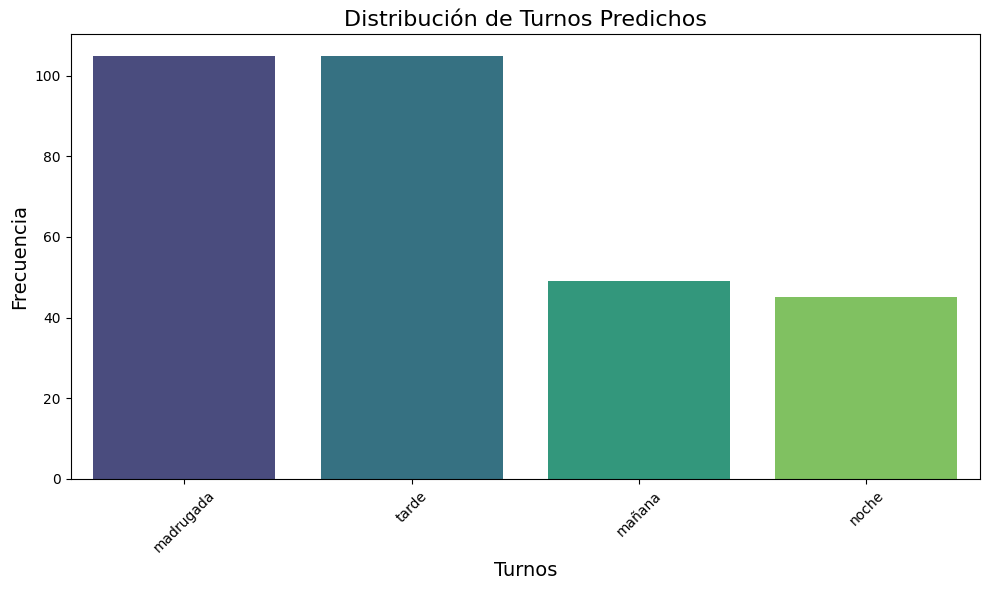

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Contar las predicciones por turno
pred_count = pd.Series(y_pred_turno).value_counts()

# Graficar las predicciones
plt.figure(figsize=(10, 6))
sns.barplot(x=pred_count.index, y=pred_count.values, palette='viridis')
plt.xlabel('Turnos', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.title('Distribución de Turnos Predichos', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

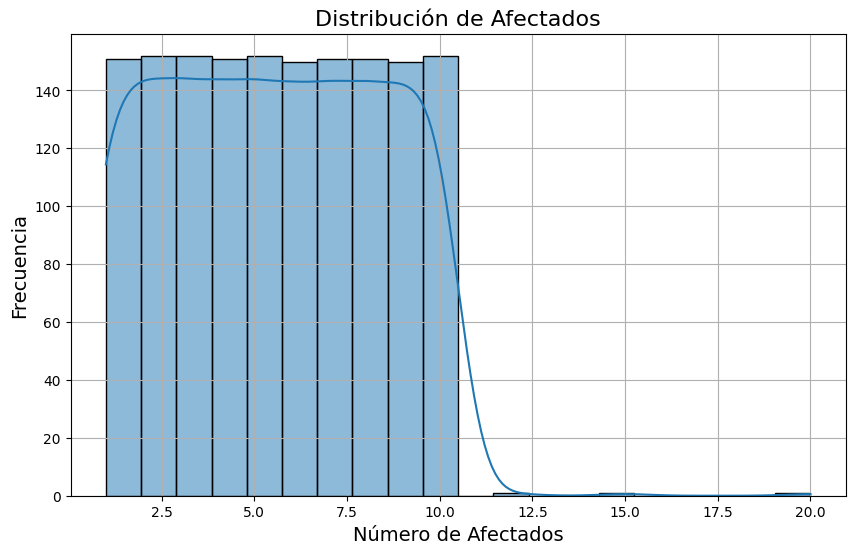

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de la variable 'afectados'
plt.figure(figsize=(10, 6))
sns.histplot(df_siniestro['afectados'], bins=20, kde=True)
plt.title('Distribución de Afectados', fontsize=16)
plt.xlabel('Número de Afectados', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True)
plt.show()


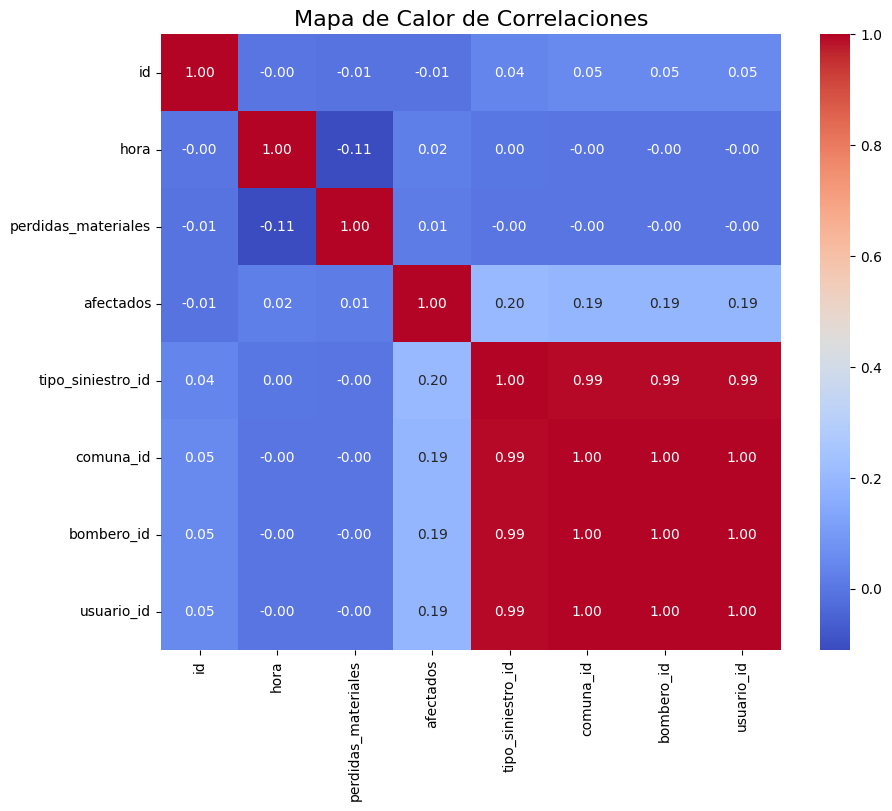

In [67]:
import numpy as np

# Filtrar solo las columnas numéricas
numerical_columns = df_siniestro.select_dtypes(include=[np.number])

# Verificar si hay columnas numéricas
if numerical_columns.empty:
    print("No hay columnas numéricas en el DataFrame para calcular la correlación.")
else:
    # Calcular la matriz de correlación
    correlation_matrix = numerical_columns.corr()

    # Graficar el mapa de calor
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Mapa de Calor de Correlaciones', fontsize=16)
    plt.show()



<ipython-input-62-dc7f6da498c2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='tipo_siniestro_id', data=df_siniestro, palette='viridis')


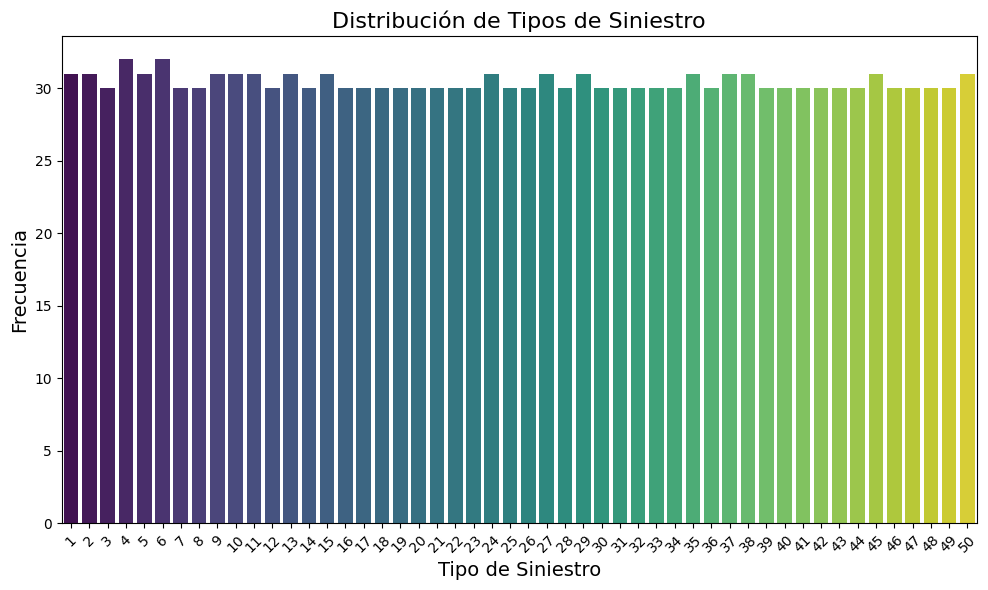

In [62]:
# Conteo de tipo de siniestros
plt.figure(figsize=(10, 6))
sns.countplot(x='tipo_siniestro_id', data=df_siniestro, palette='viridis')
plt.title('Distribución de Tipos de Siniestro', fontsize=16)
plt.xlabel('Tipo de Siniestro', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-63-3fc126dd5b3d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turno_perdidas = df_siniestro.groupby('turno')['perdidas_materiales'].mean().reset_index()
<ipython-input-63-3fc126dd5b3d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='turno', y='perdidas_materiales', data=turno_perdidas, palette='coolwarm')


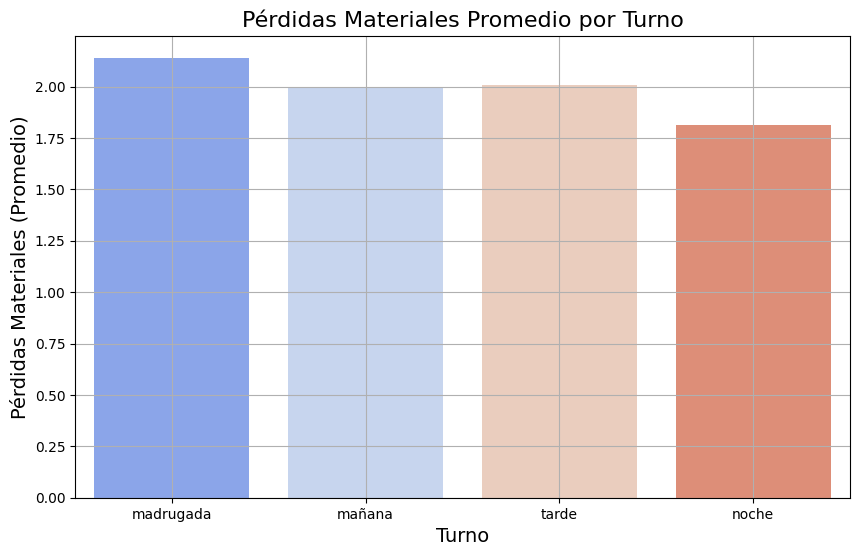

In [63]:
# Relación entre Turnos y Pérdidas Materiales
turno_perdidas = df_siniestro.groupby('turno')['perdidas_materiales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='turno', y='perdidas_materiales', data=turno_perdidas, palette='coolwarm')
plt.title('Pérdidas Materiales Promedio por Turno', fontsize=16)
plt.xlabel('Turno', fontsize=14)
plt.ylabel('Pérdidas Materiales (Promedio)', fontsize=14)
plt.grid(True)
plt.show()


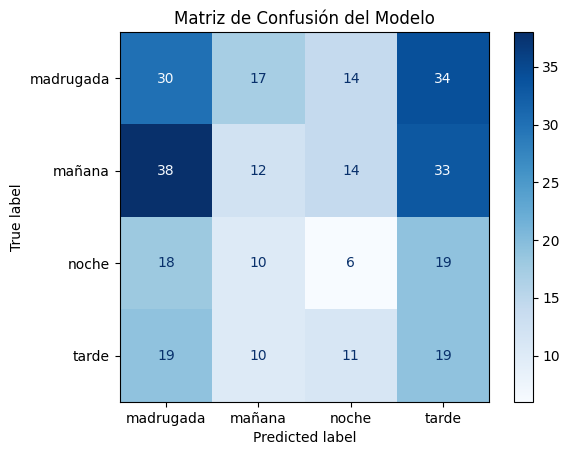

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title('Matriz de Confusión del Modelo')
plt.show()


<ipython-input-65-bdf48f5c7375>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


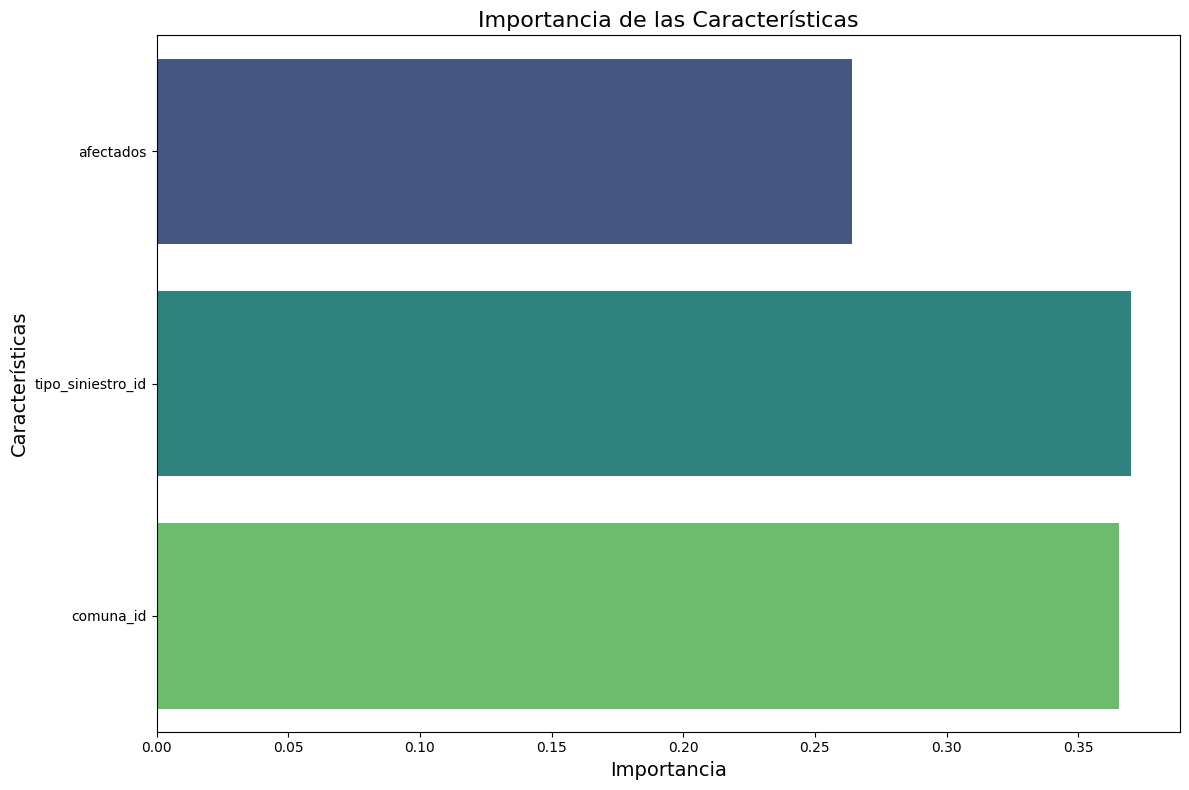

In [65]:
# Importancia de las características del modelo Random Forest
importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Importancia de las Características', fontsize=16)
plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Características', fontsize=14)
plt.tight_layout()
plt.show()
